<a href="https://colab.research.google.com/github/roquearmas/IABD_DATA/blob/main/Optimizar_CNN_ChessMan_%2B_Tensorflow_JS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Redes Convolucionales --> Tensorflow.js
Clasificación de piezas de ajedrez basadas en el dataset Chessman, exportadas a JavaScript mediante Tensorflow.js

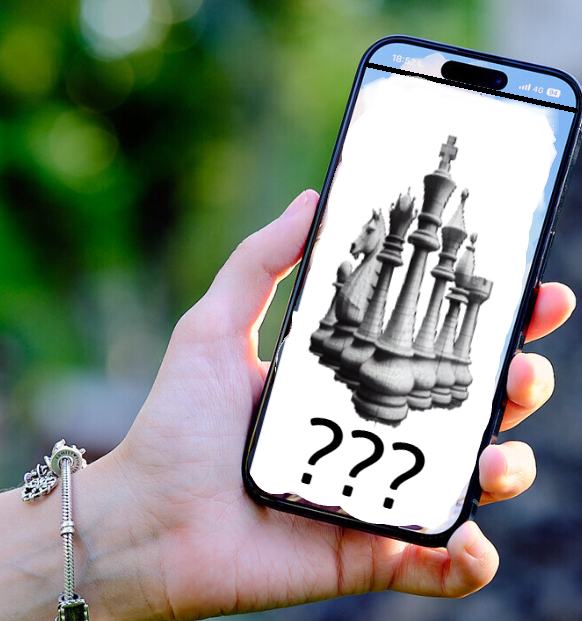


Imagen generada con [Copilot designer](https://www.bing.com/images/create)

[Términos de uso Generador de imágenes de Designer](https://www.bing.com/new/termsofuseimagecreator?FORM=GENTOS)

El dataset a utilizar consiste en imágenes registradas en subcarpetas con el nombre de los seis tipos de piezas de ajedrez; rey, reina, torre, caballo, alfil y peón.
El dataset de entrenamiento puede ser descargado desde aquí:

https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset/data

[Ruta del cuaderno en GitHub](https://github.com/roquearmas/IABD_DATA/blob/main/Optimizar_CNN_ChessMan_%2B_Tensorflow_JS.ipynb)

Jesús Roque Armas Martín - (CEIABD)

Descargo la librería split-folders, que va a separar el dataset en train, test y validation

In [ ]:
!pip install split-folders   #librería para separar el dataset en los distintos entornos
!pip install squarify==0.4.3 #para representar el diagrama de distribución de clases
!pip install imgaug          # para transformar las imágenes, generando data augmentation


Importo las librerías necesarias

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import random
import splitfolders #librería para poder dividir los datos entre los distintos datasets (train, validation y test)
import cv2
import glob
import csv
import squarify #Librería para diagrama de cuadros para representar la distribución del dataset, por clases.
import keras
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow as tf
from statistics import mean
import imgaug as ia # librería para realizar transformaciones a las imágenes y poder generar aumento de los datos
import imgaug.augmenters as iaa
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from skimage import data,filters, feature
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


Descargo el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Chessman"
print(os.listdir(path))

splitfolders.ratio(path,seed=1337, output="Chess-Splitted", ratio=(0.8, 0, 0.2))


['King', 'Queen', 'Bishop', 'Knight', 'Pawn', 'Rook']


Copying files: 2160 files [00:33, 64.48 files/s] 


(0.0, 100.0, 0.0, 100.0)

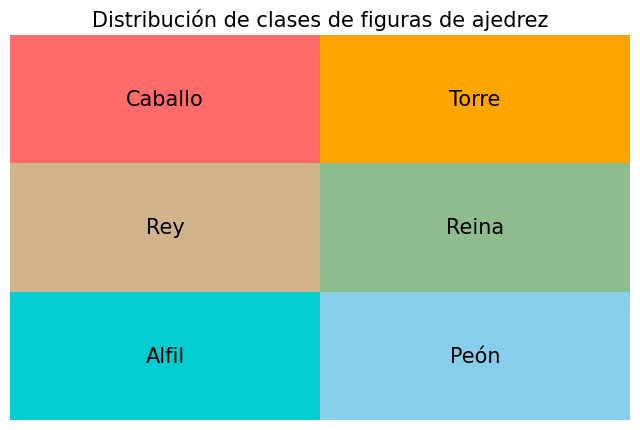

In [ ]:
raw_images_dir = "Chess-Splitted/train"

# All the class names in the correct order
class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
clases      = ['Alfil', 'Rey','Caballo', 'Peón', 'Reina','Torre']

# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(raw_images_dir, class_name))) for class_name in class_names]

# Create a squarify plot of the class distribution
fig, ax = plt.subplots(figsize = (8, 5))

colors = ["#00CED1", "#D2B48C", "#FF6B6B", "#87CEEB", "#8FBC8F", "#FFA500"]
squarify.plot(image_counts, label = clases, ax = ax, text_kwargs = {"fontsize": 15}, color = colors)

plt.title("Distribución de clases de figuras de ajedrez", fontsize = 15)
plt.axis("off")

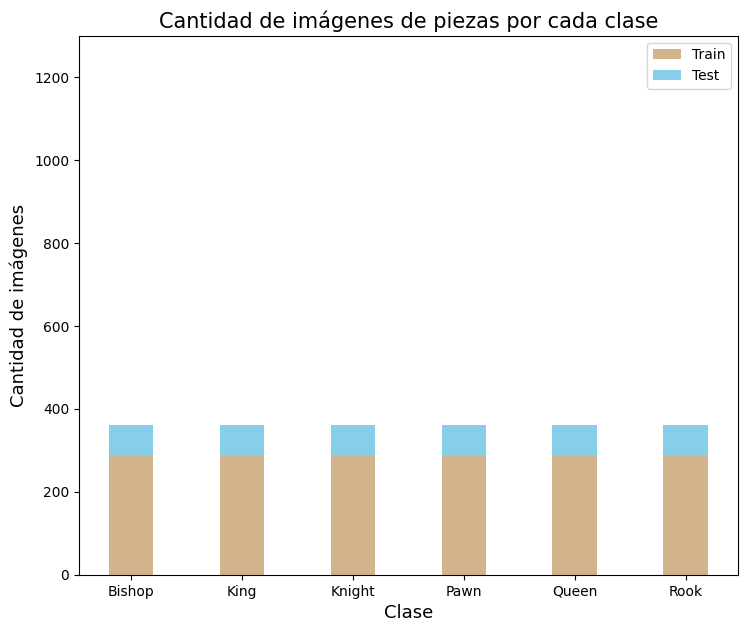

In [ ]:
# The directory where preprocessed dataset is located
pre_images_dir = 'Chess-Splitted'

# Calculate the number of images in each class for train, validation, and test sets
train_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "train", class_name))) for class_name in class_names]
val_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "val", class_name))) for class_name in class_names]
test_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "test", class_name))) for class_name in class_names]

# Convert the image count lists to numpy arrays
train_image_counts = np.array(train_image_counts)
val_image_counts = np.array(val_image_counts)
test_image_counts = np.array(test_image_counts)

# Create a bar plot of image counts for each class in each dataset split
fig, ax = plt.subplots(figsize = (8.5, 7))

ax.bar(class_names, train_image_counts, width = 0.4, label = "Train", color = "#D2B48C")
# ax.bar(class_names, val_image_counts, width = 0.4, label = "Validation", bottom = train_image_counts, color = "#00CED1")
ax.bar(class_names, test_image_counts, width = 0.4, label = "Test", bottom = train_image_counts + val_image_counts, color="#87CEEB")

# Set the y-axis limit and add labels for the x and y axes
ax.set_ylim(0,1300)
plt.ylabel("Cantidad de imágenes", fontsize = 13)
plt.xlabel("Clase", fontsize = 13)
plt.title("Cantidad de imágenes de piezas por cada clase", fontsize = 15)
ax.legend();

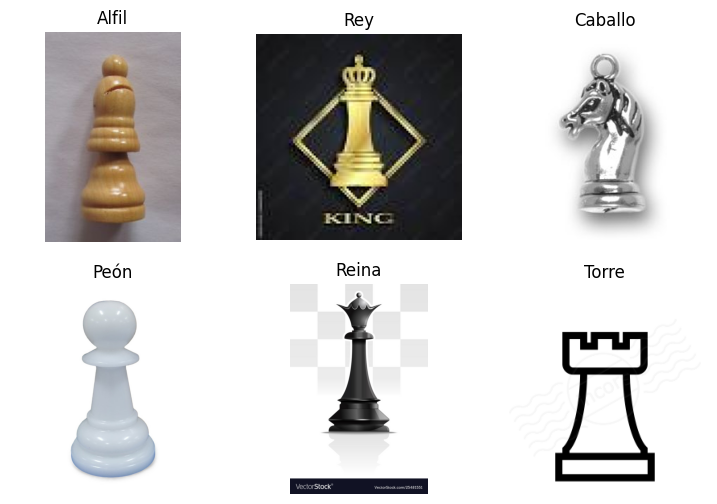

In [ ]:
# Images are loaded from the Raw Dataset directory
images = []

# Loop through all class names and pick a random image for each class
for class_name in class_names:
    image_files = os.listdir(os.path.join(raw_images_dir, class_name))
    image_file = random.choice(image_files)
    images.append(os.path.join(raw_images_dir, class_name, image_file))

# Loop through all the images and display them in the subplot
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i // 3, i % 3].imshow(plt.imread(images[i]))
    ax[i // 3, i % 3].set(title = clases[i])
    ax[i//3, i%3].axis('off');

In [ ]:
def resize_image(input_path,  target_size):
    try:
        # Abrir la imagen
        image = Image.open(input_path)

         # Convertir la imagen a un array NumPy
        image_array = np.array(image)

        # Calcular la relación de aspecto
        original_width, original_height = image_array.shape[1], image_array.shape[0]
        aspect_ratio = original_width / original_height
        # Redimensionar la imagen manteniendo la relación de aspecto
        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(target_size / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(target_size * aspect_ratio)

        resized_image =  Image.fromarray(image_array).resize((new_width, new_height))
        imagen_new=Image.new("RGB", (target_size, target_size), color="white")
        imagen_new.paste(resized_image, ((target_size - new_width) // 2, (target_size - new_height) // 2))

        # Guardar la imagen redimensionada
        imagen_new.save(input_path)
        # print(f"Imagen redimensionada guardada en {input_path}")

    except Exception as e:
        print(f"Error al redimensionar la imagen: {e}")

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):


 """Esta función carga los datos de training en imágenes.

 Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
 para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

 Args:
 dirname: directorio completo del que leer los datos
 map_characters: variable de mapeo entre labels y piezas
 verbose: si es True, muestra información de las imágenes cargadas

 Returns:
 X, y: X es un array con todas las imágenes cargadas con tamaño
 IMG SIZE x IMG SIZE
 y es un array con las labels de correspondientes a cada imagen
 """

 X_train = []
 y_train = []
 for label, character in map_characters.items():
  files = os.listdir(os.path.join(dirname, character))
  images = [file for file in files if file.lower().endswith("jpg") or file.lower().endswith("png") or file.lower().endswith("jpeg") ]
  if verbose:
    print("Leyendo {} imágenes de train encontradas de {}".format(len(images), character))

  for image_name in images:
    resize_image(os.path.join(dirname, character, image_name), 224)
    imagen = cv2.imread(os.path.join(dirname, character, image_name))
    # X_train.append(cv2.resize(image,(ancho_med, alto_med)))
    X_train.append(imagen)
    y_train.append(label)
 X_train
 return np.array(X_train), np.array(y_train)


Método para importar las imágenes de test.

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
  """Esta función funciona de manera equivalente a la función load_train_set
  pero cargando los datos de test."""
  X_test = []
  y_test = []
  for label, character in map_characters.items():
    files = os.listdir(os.path.join(dirname, character))
    images = [file for file in files if file.lower().endswith("jpg") or file.lower().endswith("png") or file.lower().endswith("jpeg") ]

    if verbose:
      print("Leyendo {} imágenes de test encontradas de {}".format(len(images), character))
    for image_name in images:
      resize_image(os.path.join(dirname, character, image_name),224)
      imagen = cv2.imread(os.path.join(dirname, character, image_name))
      X_test.append(imagen)
      y_test.append(label)
  # return np.asarray(X_test, dtype="object"), np.array(y_test)
  return np.array(X_test), np.array(y_test)



DATA Augmentation

In [ ]:
def aumentar_datos(dirname,map_characters):
  augmentations = iaa.Sequential([
    iaa.Fliplr(0.5), # Volteo horizontal con probabilidad 50%
    #iaa.Flipud(0.5), # Volteo vertical con probabilidad 50%
    iaa.Rotate((-20, 20)), # Rotación aleatoria entre -20 y 20 grados
    #iaa.Resize((0.8, 1.2)), # Escalado aleatorio entre 80% y 120%
    iaa.Crop(percent=(0.05, 0.1)), # Recorte aleatorio entre 5% y 10%
    iaa.GaussianBlur(sigma=(0.0, 1.0)), # Añadir desenfoque gaussiano aleatorio
    iaa.Add((-10, 10), per_channel=0.5), # Añadir brillo aleatorio
    iaa.Multiply((0.8, 1.2), per_channel=0.5)]) # Ajustar contraste aleatorio
    #iaa.Resize({"height": 888, "width": "keep-aspect-ratio"})
  for label, character in map_characters.items():
    files = os.listdir(os.path.join(dirname, character))
    images = [file for file in files if file.lower().endswith("jpg") or file.lower().endswith("png") or file.lower().endswith("jpeg") ]
    for image_name in images:
      imagen = cv2.imread(os.path.join(dirname, character, image_name))
      # Aplicar las transformaciones a la imagen, si es el dataset de train
      augmented_image = augmentations(image=imagen)
      # Guardar la imagen aumentada
      imagen_pil_aumentada= Image.fromarray(augmented_image)
      imagen_pil_aumentada.save(os.path.join( dirname,character,"aum_" + image_name))


Método para normalizar las imágenes, convirtiéndolas a escala de grises

In [ ]:
  def normalizar_imagenes(dirname,map_characters):
    for label, character in map_characters.items():
      files = os.listdir(os.path.join(dirname, character))
      images = [file for file in files if file.lower().endswith("jpg") or file.lower().endswith("png") or file.lower().endswith("jpeg") ]
      for image_name in images:
        imagen = cv2.imread(os.path.join(dirname, character, image_name))
        # Convierto todas las imágenes a escala de grises
        imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Normalizamos todas las imágenes a escala de grises
        imagen_gris = Image.fromarray(imagen_gris)
        imagen_gris.save(os.path.join( dirname,character, image_name))

In [ ]:
# Cargamos los datos.
DATASET_TRAIN_PATH = "/content/Chess-Splitted/train"
# DATASET_VALID_PATH = "/content/Chess-Splitted/val"
DATASET_TEST_PATH = "/content/Chess-Splitted/test"
MAP_Piezas = {0:'Bishop', 1:'King', 2:'Knight', 3:'Pawn', 4:'Queen', 5:'Rook'}

In [ ]:
aumentar_datos(DATASET_TRAIN_PATH, MAP_Piezas)
aumentar_datos(DATASET_TRAIN_PATH, MAP_Piezas)

In [ ]:
normalizar_imagenes(DATASET_TRAIN_PATH, MAP_Piezas)
normalizar_imagenes(DATASET_TEST_PATH, MAP_Piezas)

In [ ]:
X, y = load_train_set(DATASET_TRAIN_PATH, MAP_Piezas)
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_Piezas)

Leyendo 855 imágenes de train encontradas de Bishop
Leyendo 861 imágenes de train encontradas de King
Leyendo 864 imágenes de train encontradas de Knight
Leyendo 855 imágenes de train encontradas de Pawn
Leyendo 852 imágenes de train encontradas de Queen
Leyendo 864 imágenes de train encontradas de Rook
Leyendo 69 imágenes de test encontradas de Bishop
Leyendo 71 imágenes de test encontradas de King
Leyendo 72 imágenes de test encontradas de Knight
Leyendo 71 imágenes de test encontradas de Pawn
Leyendo 71 imágenes de test encontradas de Queen
Leyendo 71 imágenes de test encontradas de Rook


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de piezas, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entrenamiento

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer piezas de ajedrez. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

**Análisis de los datos a utilizar.**

In [ ]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [ ]:
# Convierte los vectores de clase a matrices keras de clase, con 6 clases
y=keras.utils.to_categorical(y,6)
y_t=keras.utils.to_categorical(y_t,6)

In [ ]:
X_train, X_val, y_train, y_val =train_test_split(X,y,test_size= 0.2)


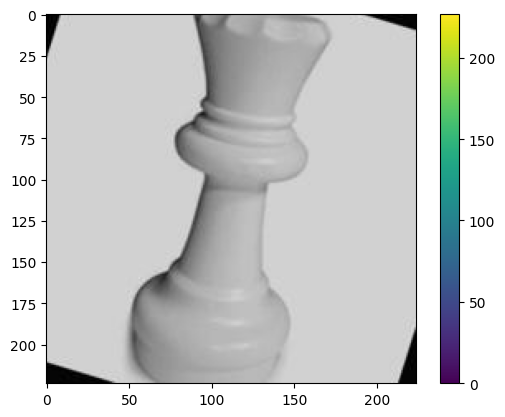

Reina
(224, 224, 3)


In [ ]:
elemento =33
visualize_example(X[elemento]) # Visualiza la imagen normalizada con valores de 0 a 1
print(clases[np.argmax(y[elemento])]) #Muestra la clase de figura del elemento
print(X[elemento].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

**Método de entrenamiento del modelo** <br>
Parámetros de entrada
Activación
Épocas
Optimizador
Loss

In [ ]:
def entrenar_modelo(activa, epocas, optimizador, loss,X, y, X_val, y_val):

  model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(224,224,3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(512, kernel_size=(3, 3), activation=activa),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  #keras.layers.Dense(500, activation=activa,kernel_regularizer=tf.keras.regularizers.l2(0.05)),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(6, activation='softmax')
  ])

  model.summary()
  model.compile(optimizer=optimizador, loss=loss, metrics=['accuracy'])

  #history=model.fit(X_train, y_train, epochs=epocas, validation_split = 0.2)
  # Define el callback para reducir el learning rate
  #lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=7, min_lr=0.0001)

  # Entrena el modelo con el callback
  #history=model.fit(X,y,  epochs=epocas, validation_split=0.2, callbacks=[lr_scheduler], validation_data=(X_val, y_val))
  history=model.fit(X,y,  epochs=epocas, validation_split=0.2, validation_data=(X_val, y_val))

  return history, model

# Entrenar modelo

In [ ]:
# history, model=entrenar_modelo('relu',20,'adam','categorical_crossentropy',filtro_tf, y)
%%time
history, model=entrenar_modelo('relu',26,'rmsprop','categorical_crossentropy',X_train, y_train, X_val, y_val)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 512)       590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 512)       0

**Análisis visual de los errores de la red.**

In [ ]:
def plot_acc(history, title="Accuracy del modelo"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Loss del modelo"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

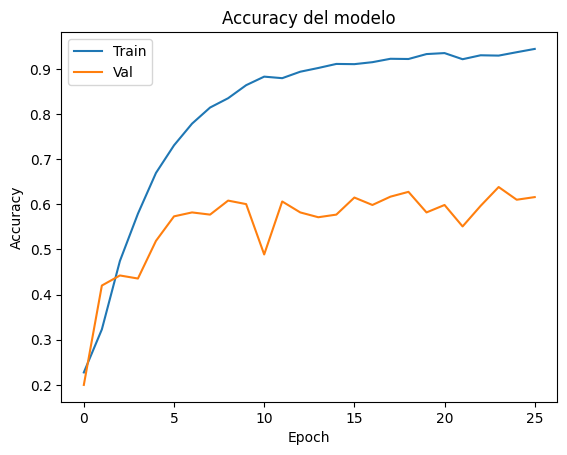

In [ ]:
plot_acc(history)

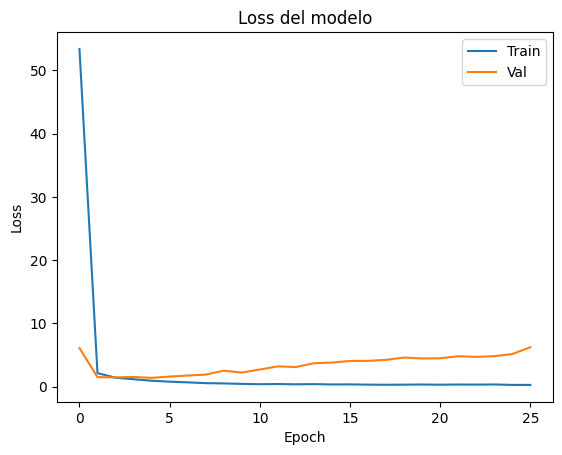

In [ ]:
plot_loss(history)

*Viendo las gráficas observamos que con 5 épocas las líneas de loss y accuracy se vuelven prácticamente horizontales, por eso no seguimos entrenando.*

**Evaluación de los datos de test con este modelo.**

**Almacenamos todas las predicciones para los datos de test.**

In [ ]:
prediccion=model.predict(X_t)  # Almacenamos todas las predicciones para los datos de test

14/14 [==============================] - 1s 67ms/step


Probar un elemento cualquiera

[9.9999392e-01 2.1807081e-07 1.5357512e-11 2.6085970e-11 5.8618070e-06
 3.5045278e-09]
0
Predicción:  Alfil


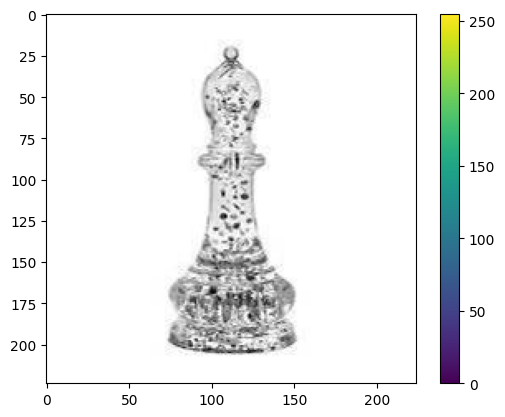

In [ ]:
elemento = 10
print(prediccion[elemento]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[elemento])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 6 clases.
print(predicho)
print('Predicción: ',clases[predicho]) # Acceso al diccionario para mostrar el nombre del personaje predicho.
visualize_example(X_t[elemento])


**Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados.**

In [ ]:
informe = classification_report(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1),target_names=clases, zero_division=0)
print(informe)


              precision    recall  f1-score   support

       Alfil       0.81      0.74      0.77        69
         Rey       0.68      0.73      0.71        71
     Caballo       0.76      0.81      0.78        72
        Peón       0.78      0.66      0.72        71
       Reina       0.73      0.75      0.74        71
       Torre       0.77      0.83      0.80        71

    accuracy                           0.75       425
   macro avg       0.76      0.75      0.75       425
weighted avg       0.76      0.75      0.75       425




# Exportación del modelo a Tensorflow js



In [ ]:
model.save('chessman_cnn.h5')
#tf.keras.models.save_model(model, 'model/my_model', save_format='tf')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir salida

In [ ]:
!tensorflowjs_converter --input_format keras /content/chessman_cnn.h5 salida

2024-04-26 16:43:34.052537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 16:43:35.064071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
